# Read, Parse, Process E-Commerce data on PySpark
eCommerce dataset: https://www.kaggle.com/mkechinov/ecommerce-behavior-data-from-multi-category

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

## Data Download from Kaggle

In [3]:
# ! pip install kaggle --upgrade

     |████████████████████████████████| 58 kB 2.0 MB/s eta 0:00:011
     |████████████████████████████████| 118 kB 11.3 MB/s eta 0:00:01
     |████████████████████████████████| 78 kB 12.1 MB/s eta 0:00:01
  Created wheel for kaggle: filename=kaggle-1.5.6-py3-none-any.whl size=72859 sha256=f6df588ba0dce2fdaa560c7260b6f24d4c3d19dddd40a82c5f8e59d4fb7e44e1
  Stored in directory: /home/jovyan/.cache/pip/wheels/aa/e7/e7/eb3c3d514c33294d77ddd5a856bdd58dc9c1fabbed59a02a2b
  Created wheel for python-slugify: filename=python_slugify-4.0.0-py2.py3-none-any.whl size=5486 sha256=ccd5fc462f4c2e3aff0d34f878d667cdf53acd018d64939570e8ce3c1ede5e4e
  Stored in directory: /home/jovyan/.cache/pip/wheels/7c/26/30/5f3d95da00fe94d0c4a5ec5b4ffd2e1ae18545f5fa61752e52
Successfully built kaggle python-slugify
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.25.9
    Uninstalling urllib3-1.25.9:
      Successfully uninstalled urllib3-1.25.9


In [17]:
# NOTE: first to get kaggle api tiken from account page in Kaggle. Place it at ~/.kaggle/kaggle.json
# mkdir ~/.kaggle/
# nano ~/.kaggle/kaggle.json
# chmod 600 ~/.kaggle/kaggle.json
# kaggle datasets download mkechinov/ecommerce-behavior-data-from-multi-category-store
# unzip ecommerce-behavior-data-from-multi-category-store.zip

## Setup Spark

In [2]:
import pyspark
import pyspark.sql.functions as F
from pyspark.sql.functions import udf
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.types import *
from pyspark.ml.recommendation import ALS
from pyspark.sql import Window
from pyspark.ml.linalg import Vectors, Vector, DenseVector, SparseVector, VectorUDT
from pyspark.ml.stat import Summarizer

In [3]:
from pyspark.sql import SparkSession

# Setup for 400GB Mem machine
config = pyspark.SparkConf().setAll([('spark.executor.memory', '350g'),
                                     ('spark.executor.instances', '1'),
                                     ('spark.cores.max', '64'),
                                     #('spark.cores.max', '3'),
                                     ('spark.executor.cores', '64'),
                                     ('spark.driver.memory','30g')
                                    ])
spark = SparkSession.builder.config(conf=config).appName("JobName").getOrCreate()

# Setup for 200GB Mem machine
# config = pyspark.SparkConf().setAll([('spark.executor.cores', '4'),
#                                      ('spark.executor.instances', '2'),
#                                      ('spark.executor.memory', '12g'), 
#                                      ('spark.executor.memoryOverhead', '2g'), 
#                                      #('spark.driver.cores', '4'),
#                                      #('spark.driver.memory', '12g'),
#                                      ('spark.dynamicAllocation.enabled', 'false'),
#                                      ('spark.io.compression.codec', 'snappy')
#                                     ])

# spark = SparkSession.builder.config(conf=config).appName("Recsys-Transformer-Research").getOrCreate()

## Read Data

#### Load 4 months dataset

In [4]:
data_csv_01 = "./2019-Oct.csv"
data_csv_02 = "./2019-Nov.csv"
# data_csv_03 = "/workspace/ecommerce-behavior-data-from-multi-category-store/2019-Dec.csv"
# data_csv_04 = "/workspace/ecommerce-behavior-data-from-multi-category-store/2020-Jan.csv"

# data_list = [data_csv_01, data_csv_02]
data_list = [data_csv_01]

#### Read through Spark from CSV

In [5]:
_df_sb = spark.read.csv(data_list, inferSchema = True, header = True)
_df_sb.printSchema()

root
 |-- event_time: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- category_id: long (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = true)



#### Convert timestamp as the type of datetime

In [6]:
_df_sb_a = _df_sb.withColumn('event_time_dt', F.to_timestamp('event_time','yyyy-MM-dd HH:mm:ss'))

In [7]:
_df_sb_a = _df_sb_a.withColumn('et_hour', F.hour('event_time_dt'))\
                .withColumn('et_dayofweek', F.dayofweek('event_time_dt'))\
                .withColumn('et_dayofmonth', F.dayofmonth('event_time_dt'))\
                .withColumn('et_month', F.month('event_time_dt'))

#### String -> Discrete Feature

API: https://spark.apache.org/docs/latest/api/python/pyspark.ml.html?pyspark.ml.feature.StringIndexer#pyspark.ml.feature.StringIndexer

How to apply:
https://stackoverflow.com/questions/36942233/apply-stringindexer-to-several-columns-in-a-pyspark-dataframe

In [8]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

product_idxer = StringIndexer(inputCol="product_id", outputCol="product_idx", handleInvalid="error", stringOrderType="frequencyDesc")
category_idxer = StringIndexer(inputCol="category_id", outputCol="category_idx", handleInvalid="error", stringOrderType="frequencyDesc")
userid_idxer = StringIndexer(inputCol="user_id", outputCol="user_idx", handleInvalid="skip", stringOrderType="frequencyDesc")
usersession_idxer = StringIndexer(inputCol="user_session", outputCol="user_session_idx", handleInvalid="skip", stringOrderType="frequencyDesc")
brand_idxer = StringIndexer(inputCol="brand", outputCol="brand_idx", handleInvalid="skip", stringOrderType="frequencyDesc")

#NOTE: userid_idxer gets error!

indexers = [product_idxer, category_idxer, brand_idxer, ]# product_idxer, category_idxer,userid_idxer, usersession_idxer, brand_idxer]
pipeline = Pipeline(stages = indexers)
         
index_model = pipeline.fit(_df_sb_a)
_df_sb_a_r = index_model.transform(_df_sb_a)

+--------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+-------------------+-------+------------+-------------+--------+-----------+------------+---------+
|          event_time|event_type|product_id|        category_id|       category_code|   brand|  price|  user_id|        user_session|      event_time_dt|et_hour|et_dayofweek|et_dayofmonth|et_month|product_idx|category_idx|brand_idx|
+--------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+-------------------+-------+------------+-------------+--------+-----------+------------+---------+
|2019-10-01 00:00:...|      view|  44600062|2103807459595387724|                null|shiseido|  35.79|541312140|72d76fde-8bb3-4e0...|2019-10-01 00:00:00|      0|           3|            1|      10|    30797.0|       380.0|    595.0|
|2019-10-01 00:00:...|      view|   3900821|2053013552326770905|appl

#### Add +3 to indexed columns

In [9]:
start_idx = 3

_df_sb_a_r = _df_sb_a_r.withColumn('product_idx', F.col('product_idx')+start_idx)\
            .withColumn('category_idx', F.col('category_idx')+start_idx)\
            .withColumn('brand_idx', F.col('brand_idx')+start_idx)
#             .withColumn('user_idx', F.col('user_idx')+1)\
#             .withColumn('user_session_idx', F.col('user_session_idx')+1)\

+--------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+-------------------+-------+------------+-------------+--------+-----------+------------+---------+
|          event_time|event_type|product_id|        category_id|       category_code|   brand|  price|  user_id|        user_session|      event_time_dt|et_hour|et_dayofweek|et_dayofmonth|et_month|product_idx|category_idx|brand_idx|
+--------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+-------------------+-------+------------+-------------+--------+-----------+------------+---------+
|2019-10-01 00:00:...|      view|  44600062|2103807459595387724|                null|shiseido|  35.79|541312140|72d76fde-8bb3-4e0...|2019-10-01 00:00:00|      0|           3|            1|      10|    30798.0|       381.0|    596.0|
|2019-10-01 00:00:...|      view|   3900821|2053013552326770905|appl

### Change type to INT

In [104]:
_df_sb_a_r = _df_sb_a_r.withColumn('product_idx', F.col('product_idx').cast(IntegerType()))\
            .withColumn('category_idx', F.col('category_idx').cast(IntegerType()))\
            .withColumn('brand_idx', F.col('brand_idx').cast(IntegerType()))

### Get statistics

In [32]:
from pyspark.sql.functions import countDistinct
gr = _df_sb_a_r.agg(countDistinct("user_session"))
gr.show()

+----------------------------+
|count(DISTINCT user_session)|
+----------------------------+
|                    12731393|
+----------------------------+



In [33]:
gr = _df_sb_a_r.agg(countDistinct("user_id"))
gr.show()

+-----------------------+
|count(DISTINCT user_id)|
+-----------------------+
|                3504600|
+-----------------------+



In [34]:
gr = _df_sb_a_r.agg(countDistinct("product_id"))
gr.show()

+--------------------------+
|count(DISTINCT product_id)|
+--------------------------+
|                    146312|
+--------------------------+



In [35]:
gr = _df_sb_a_r.agg(countDistinct("category_id"))
gr.show()

+---------------------------+
|count(DISTINCT category_id)|
+---------------------------+
|                        675|
+---------------------------+



#### Normalize Continuous Feature

api: http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html?highlight=standardscaler#pyspark.mllib.feature.StandardScaler

TODO: change column to array (vector) type to run it 

In [30]:
# from pyspark.ml.feature import StandardScaler

# scaler = StandardScaler(inputCol="price", outputCol="price_scl",
#                         withStd=True, withMean=False)
# model = scaler.fit(_df_sb_a_r)
# _df_sb_a_r = model.transform(dataset)

#### Aggregate by session id (create sequence as type of array)

In [106]:
window = Window.partitionBy('user_session').orderBy('event_time_dt')



In [107]:

_df_sb_a_r = _df_sb_a_r.withColumn('ux_event_time', F.unix_timestamp('event_time_dt'))
_df_sb_a_r = _df_sb_a_r.withColumn('prev_event_time', F.lag('ux_event_time').over(window))


In [108]:
_df_sb_a_wprevt = _df_sb_a_r.withColumn('delta_event_time',F.when(F.isnull(F.col('prev_event_time')), 0).otherwise(F.col('ux_event_time') - F.col('prev_event_time')))



In [109]:
_df_sb_a_wprevt.printSchema()

root
 |-- event_time: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- category_id: long (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = true)
 |-- event_time_dt: timestamp (nullable = true)
 |-- et_hour: integer (nullable = true)
 |-- et_dayofweek: integer (nullable = true)
 |-- et_dayofmonth: integer (nullable = true)
 |-- et_month: integer (nullable = true)
 |-- product_idx: integer (nullable = true)
 |-- category_idx: integer (nullable = true)
 |-- brand_idx: integer (nullable = true)
 |-- ux_event_time: long (nullable = true)
 |-- prev_event_time: long (nullable = true)
 |-- delta_event_time: long (nullable = true)



In [110]:
df_sb_grouped_df = _df_sb_a_wprevt \
                .select('user_session', 
                        F.collect_list('product_idx').over(window ).alias('pid_seq_als'), \
                        F.collect_list('category_idx').over(window ).alias('cid_seq_als'),\
                        F.collect_list('brand_idx').over(window ).alias('bid_seq_als'),\
                        F.collect_list('price').over(window ).alias('price_seq_als'),\
                        F.collect_list('ux_event_time').over(window ).alias('etime_seq_als'),\
                        F.collect_list('delta_event_time').over(window).alias('dtime_seq_als'),\
                        F.collect_list('et_hour').over(window).alias('et_hour_seq_als'),\
                        F.collect_list('et_month').over(window).alias('et_month_seq_als'),\
                        F.collect_list('et_dayofweek').over(window).alias('et_dayofweek_seq_als'),\
                        F.collect_list('et_dayofmonth').over(window).alias('et_dayofmonth_seq_als'),\
                       )\
                .groupBy('user_session').agg(
                    F.max('pid_seq_als').alias('pid_seq'),
                    F.max('cid_seq_als').alias('cid_seq'),
                    F.max('bid_seq_als').alias('bid_seq'),
                    F.max('price_seq_als').alias('price_seq'),
                    F.max('etime_seq_als').alias('etime_seq'),
                    F.max('dtime_seq_als').alias('dtime_seq'),
                    F.max('et_hour_seq_als').alias('et_hour_seq'),
                    F.max('et_month_seq_als').alias('et_month_seq'),
                    F.max('et_dayofweek_seq_als').alias('et_dayofweek_seq'),
                    F.max('et_dayofmonth_seq_als').alias('et_dayofmonth_seq'),
)


In [111]:
df_sb_grouped_df.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|        user_session|             pid_seq|             cid_seq|             bid_seq|           price_seq|           etime_seq|           dtime_seq|         et_hour_seq|        et_month_seq|    et_dayofweek_seq|   et_dayofmonth_seq|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|00019495-9f33-48f...|                [39]|                 [1]|                 [1]|             [88.52]|        [1572188370]|                 [0]|                [14]|                [10]|                 [1]|                [27]|
|0002854a-13ef-490...|[7419, 10791, 239...|[2, 2, 2, 2, 2, 2...|[181

In [112]:
df_sb_grouped_df.printSchema()

root
 |-- user_session: string (nullable = true)
 |-- pid_seq: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- cid_seq: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- bid_seq: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- price_seq: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- etime_seq: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- dtime_seq: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- et_hour_seq: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- et_month_seq: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- et_dayofweek_seq: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- et_dayofmonth_seq: array (nullable = true)
 |    |-- element: integer (containsNull = true)



#### Check lengths of sequences

In [113]:
@udf(returnType=IntegerType())
def get_array_len(arr):
    return len(arr)

df_sb_grouped_df_len = df_sb_grouped_df.withColumn("seq_len", F.size(F.col("pid_seq")))
# df_sb_grouped_df_len = df_sb_grouped_df.withColumn("seq_len", get_array_len(F.col("pid_seq")))


df_sb_grouped_df_len.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------+
|        user_session|             pid_seq|             cid_seq|             bid_seq|           price_seq|           etime_seq|           dtime_seq|         et_hour_seq|        et_month_seq|    et_dayofweek_seq|   et_dayofmonth_seq|seq_len|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------+
|00019495-9f33-48f...|                [39]|                 [1]|                 [1]|             [88.52]|        [1572188370]|                 [0]|                [14]|                [10]|                 [1]|                [27]|      1|
|0002854a-13ef-490...|[7419, 10791, 

In [27]:
# ! conda install seaborn
import seaborn as sns # visualizations
import matplotlib.pyplot as plt

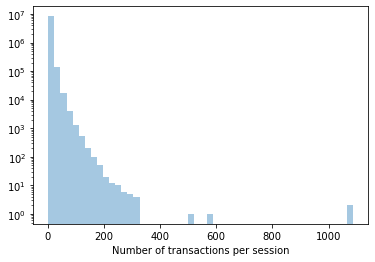

In [90]:
seq_lengths = df_sb_grouped_df_len.select('seq_len')
seq_lengths_pd = seq_lengths.toPandas()
ax = sns.distplot(seq_lengths_pd, hist=True, kde=False, axlabel="Number of transactions per session")
ax.set_yscale('log')

In [38]:
seq_lengths_pd['seq_len'].value_counts(bins=10)

(-0.08600000000000001, 109.5]    8517057
(109.5, 218.0]                       886
(218.0, 326.5]                        37
(977.5, 1086.0]                        2
(543.5, 652.0]                         1
(435.0, 543.5]                         1
(869.0, 977.5]                         0
(760.5, 869.0]                         0
(652.0, 760.5]                         0
(326.5, 435.0]                         0
Name: seq_len, dtype: int64

In [117]:
# by the data
# max_length = df_sb_grouped_df.select(F.max(F.size(F.col('pid_seq'))).alias('max_length')).take(1)[0]['max_length']

# by manual
max_length = 20

### Filter out sequence w/ shorter (len=1) 

In [118]:
df_sb_grouped_df_len_fl = df_sb_grouped_df_len.where(F.col("seq_len")>1)

In [119]:
df_sb_grouped_df_len_fl.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------+
|        user_session|             pid_seq|             cid_seq|             bid_seq|           price_seq|           etime_seq|           dtime_seq|         et_hour_seq|        et_month_seq|    et_dayofweek_seq|   et_dayofmonth_seq|seq_len|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------+
|0002854a-13ef-490...|[7419, 10791, 239...|[2, 2, 2, 2, 2, 2...|[181, 181, 233, 6...|[27.54, 29.47, 29...|[1571867123, 1571...|[0, 36, 5, 8, 11,...|[21, 21, 21, 21, ...|[10, 10, 10, 10, ...|[4, 4, 4, 4, 4, 4...|[23, 23, 23, 23, ...|     10|
|0002af2d-cbff-455...|[4442, 4442, 4

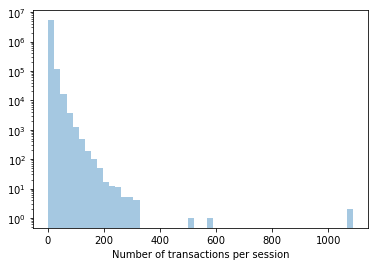

In [120]:
seq_lengths_pd_fl = df_sb_grouped_df_len_fl.select('seq_len').toPandas()
ax = sns.distplot(seq_lengths_pd_fl, hist=True, kde=False, axlabel="Number of transactions per session")
ax.set_yscale('log')

In [121]:
seq_lengths_pd['seq_len'].value_counts(bins=10)

(0.915, 110.4]     5432441
(110.4, 218.8]         852
(218.8, 327.2]          37
(977.6, 1086.0]          2
(544.0, 652.4]           1
(435.6, 544.0]           1
(869.2, 977.6]           0
(760.8, 869.2]           0
(652.4, 760.8]           0
(327.2, 435.6]           0
Name: seq_len, dtype: int64

#### Remove repeating items (keep the order of their first occurrence)

In [141]:
@udf(returnType=ArrayType(StringType()))
def get_non_repeated_addtional_items(item_ids, additional_feature_values):
    #Returns unique items, keep the order of their first occurence
    ids = []
    result = []
    for i, v in zip(item_ids, additional_feature_values):
        if i not in ids:
            ids.append(i)
            result.append(v)
    return result

@udf(returnType=ArrayType(StringType()))
def get_non_repeated_items(values):
    #Returns unique items, keep the order of their first occurence
    result = []
    for v in values:
        if v not in result:
            result.append(v)
    return result

# nr: non-repeated
df_sb_grouped_df_len_fl_nr = df_sb_grouped_df_len_fl\
    .withColumn("pid_seq_nr", get_non_repeated_items(F.col("pid_seq")))\
    .withColumn("price_seq_nr", get_non_repeated_items(F.col("price_seq")))\
    .withColumn("cid_seq_nr", get_non_repeated_addtional_items(F.col("pid_seq"), F.col("cid_seq")))\
    .withColumn("etime_seq_nr", get_non_repeated_addtional_items(F.col("pid_seq"), F.col("etime_seq")))\
    .withColumn("dtime_seq_nr", get_non_repeated_addtional_items(F.col("pid_seq"), F.col("dtime_seq")))\
    .withColumn("et_hour_seq_nr", get_non_repeated_addtional_items(F.col("pid_seq"), F.col("et_hour_seq")))\
    .withColumn("et_month_seq_nr", get_non_repeated_addtional_items(F.col("pid_seq"), F.col("et_month_seq")))\
    .withColumn("et_dayofweek_seq_nr", get_non_repeated_addtional_items(F.col("pid_seq"), F.col("et_dayofweek_seq")))\
    .withColumn("et_dayofmonth_seq_nr", get_non_repeated_addtional_items(F.col("pid_seq"), F.col("et_dayofmonth_seq")))




#### Option A: Pad zeros to make all sequences same length
NOTE: it would be not memory-efficient. But currently it seems no way to utilize Petastorm (parquest -> dataloader) without this option.

In [122]:
# take small sample
# small = df_sb_grouped_df_len_fl.sample(False, 0.000001, seed=0).limit(1000)
# small.show()



In [142]:
from pyspark.sql.types import ArrayType, IntegerType


def pad_array(values, expected_length):
    res = values + [0] * (expected_length-len(values))
    # NOTE: cut first N
    res = res[:expected_length]
    return res


@udf(returnType=ArrayType(IntegerType()))
def pad_array_int(values, expected_length):
    return pad_array(values, expected_length)

@udf(returnType=ArrayType(LongType()))
def pad_array_long(values, expected_length):
    return pad_array(values, expected_length)

@udf(returnType=ArrayType(FloatType()))
def pad_array_float(values, expected_length):
    return pad_array(values, expected_length)


df_sb_grouped_df_zpd_nr = df_sb_grouped_df_len_fl_nr\
    .withColumn("pid_seq_zpd", pad_array_long(F.col("pid_seq"), F.lit(max_length)))\
    .withColumn("cid_seq_zpd", pad_array_long(F.col("cid_seq"), F.lit(max_length)))\
    .withColumn("price_seq_zpd", pad_array_float(F.col("price_seq"), F.lit(max_length)))\
    .withColumn("etime_seq_zpd", pad_array_long(F.col("etime_seq"), F.lit(max_length)))\
    .withColumn("dtime_seq_zpd", pad_array_long(F.col("dtime_seq"), F.lit(max_length)))\
    .withColumn("et_hour_seq_zpd", pad_array_int(F.col("et_hour_seq"), F.lit(max_length)))\
    .withColumn("et_month_seq_zpd", pad_array_int(F.col("et_month_seq"), F.lit(max_length)))\
    .withColumn("et_dayofweek_seq_zpd", pad_array_int(F.col("et_dayofweek_seq"), F.lit(max_length)))\
    .withColumn("et_dayofmonth_seq_zpd", pad_array_int(F.col("et_dayofmonth_seq"), F.lit(max_length)))           


In [ ]:
df_sb_grouped_df_zpd.describe().show()

In [137]:
df_sb_grouped_df_zpd_nr.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------------+
|        user_session|             pid_seq|             cid_seq|             bid_seq|           price_seq|           etime_seq|           dtime_seq|         et_hour_seq|        et_month_seq|    et_dayofweek_seq|   et_dayofmonth_seq|seq_len|          pid_seq_nr|          cid_seq_nr|        etime_seq_nr|        dtime_seq_nr|      et_hour_seq_nr|     et_month_seq_nr| et_dayofweek_seq_nr|et_dayofmonth_seq_nr|         pid_s

## Split Train/Test

In [143]:
df_train, df_val = df_sb_grouped_df_zpd_nr.randomSplit([0.9, 0.1], seed=12345)

# Make sure the number of partitions is at least the number of workers which is required for distributed training.
df_train = df_train.repartition(2)
df_val = df_val.repartition(2)


## Data Load on PyTorch (Example)

Reference: PetaStorm (allow us to load parquet data in PyTorch or Tensorflow
- https://docs.databricks.com/applications/deep-learning/data-prep/petastorm.html#
- https://petastorm.readthedocs.io/en/latest/api.html?highlight=array#petastorm.spark.spark_dataset_converter.vector_to_array


In [169]:
# ! conda install pytorch torchvision cudatoolkit=10.2 -c pytorch -y

Solving environment: / ^C
- 

In [ ]:
# !pip install petastorm


In [44]:
from petastorm.spark import SparkDatasetConverter, make_spark_converter


### Cache the Spark DataFrame using Petastorm Spark converter


In [45]:
! mkdir -p /home/jovyan/tmp/petastorm/cache

In [144]:
# Set a cache directory on DBFS FUSE for intermediate data.
spark.conf.set(SparkDatasetConverter.PARENT_CACHE_DIR_URL_CONF, "file:///home/jovyan/tmp/petastorm/cache")

converter_train = make_spark_converter(df_train)
converter_val = make_spark_converter(df_val)


Converting floating-point columns to float32
Converting floating-point columns to float32


### Show current cached file path

In [160]:
converter_train.file_urls

['file:///home/jovyan/tmp/petastorm/cache/20200617044630-appid-local-1592357472062-5618370f-419b-4421-be76-1ef1bc3df293/part-00000-e9c67d19-de9c-4ba0-934d-7becf19a483c-c000.parquet',
 'file:///home/jovyan/tmp/petastorm/cache/20200617044630-appid-local-1592357472062-5618370f-419b-4421-be76-1ef1bc3df293/part-00001-e9c67d19-de9c-4ba0-934d-7becf19a483c-c000.parquet']

In [161]:
converter_val.file_urls

['file:///home/jovyan/tmp/petastorm/cache/20200617045047-appid-local-1592357472062-4796c1ec-0f9a-4ddb-b736-66a0ca1acb99/part-00000-e40aad43-ebb1-47d1-ad55-5f2ee63d9034-c000.parquet',
 'file:///home/jovyan/tmp/petastorm/cache/20200617045047-appid-local-1592357472062-4796c1ec-0f9a-4ddb-b736-66a0ca1acb99/part-00001-e40aad43-ebb1-47d1-ad55-5f2ee63d9034-c000.parquet']

In [148]:
print(f"train: {len(converter_train)}, val: {len(converter_val)}")


train: 4890191, val: 543143


#### Create Petastorm Data Schema
Currently we're not using this choice. This could be used to create custom Petastorm data schema to load variable-length array into dataloder

API: https://petastorm.readthedocs.io/en/latest/api.html?module-petastorm.codecs
Example: https://github.com/uber/petastorm/blob/9a903d9885759674f81b412dc133aeb9577e00dd/examples/spark_dataset_converter/pytorch_converter_example.py

In [48]:
from petastorm.unischema import UnischemaField
from petastorm.unischema import Unischema

from petastorm.codecs import NdarrayCodec


In [176]:
recsys_schema = [
#     UnischemaField('user_session', np.string_, (None), NdarrayCodec(), True),
    UnischemaField('pid_seq_zpd', np.longlong, (None), NdarrayCodec(), True),
    UnischemaField('cid_seq_zpd', np.longlong, (None), NdarrayCodec(), True),
    UnischemaField('dtime_seq_zpd', np.int, (None), NdarrayCodec(), True),
    UnischemaField('et_hour_seq_zpd', np.int, (None), NdarrayCodec(), True),
    UnischemaField('et_month_seq_zpd', np.int, (None), NdarrayCodec(), True), 
    UnischemaField('et_dayofweek_seq_zpd', np.int, (None), NdarrayCodec(), True),
    UnischemaField('et_dayofmonth_seq_zpd', np.int, (None), NdarrayCodec(), True),
]

recsys_schema_pid = [
    UnischemaField('pid_seq_zpd', np.longlong, (None), NdarrayCodec(), True),
]

### Sample PyTorch DataLoader

In [ ]:
BATCH_SIZE = 64
NUM_EPOCHS = 1

In [147]:
#     , \
#        converter_val.make_torch_dataloader(batch_size=BATCH_SIZE, schema_fields=RecSysSchema) as val_dataloader:


with converter_train.make_torch_dataloader(batch_size=BATCH_SIZE, schema_fields=recsys_schema) as train_dataloader:

    train_dataloader_iter = iter(train_dataloader)
    steps_per_epoch = len(converter_train) // BATCH_SIZE

#         val_dataloader_iter = iter(val_dataloader)
#         validation_steps = max(1, len(converter_val) // BATCH_SIZE)

    device = None

    for epoch in range(NUM_EPOCHS):
        print('Epoch {}/{}'.format(epoch + 1, NUM_EPOCHS))
        print('-' * 10)

        train_one_epoch(train_dataloader_iter, steps_per_epoch, epoch, device)
        #           val_loss, val_acc = evaluate(val_dataloader_iter, validation_steps, device)
        break


Epoch 1/1
----------


/opt/conda/lib/python3.7/site-packages/petastorm/arrow_reader_worker.py:53: FutureWarning: Calling .data on ChunkedArray is provided for compatibility after Column was removed, simply drop this attribute
  column_as_pandas = column.data.chunks[0].to_pandas()


p_seq:tensor([[ 4442,  4442,  4442,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
        [   60,   780,   231,   338,  1093,   780,   957,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
        [ 2186,  1480,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
        [   16,    22,    81,  2509,    16,    16,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
        [ 3080,  3080,  3080,  3080,  3080,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
        [  220,   220,   220,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
        [22442, 22442, 30424, 49989, 622

In [70]:
def train_one_epoch(train_dataloader_iter, steps_per_epoch, epoch, device=None):
    for step in range(steps_per_epoch):
        pd_batch = next(train_dataloader_iter)
        # u_sess = pd_batch['user_session'].to(device)
        p_seq = pd_batch['pid_seq_zpd'].to(device)
        c_seq = pd_batch['cid_seq_zpd'].to(device)
        d_seq = pd_batch['dtime_seq_zpd'].to(device)
        eth_seq = pd_batch['et_hour_seq_zpd'].to(device)
        etm_seq = pd_batch['et_month_seq_zpd'].to(device)
        etdw_seq = pd_batch['et_dayofweek_seq_zpd'].to(device)
        etdm_seq = pd_batch['et_dayofmonth_seq_zpd'].to(device)
        
        print("p_seq:{}".format(p_seq))
        print("c_seq:{}".format(c_seq))
        print("d_seq:{}".format(d_seq))
        print("eth_seq:{}".format(eth_seq))
        print("etm_seq:{}".format(etm_seq))
        print("etdw_seq:{}".format(etdw_seq))
        print("etdm_seq:{}".format(etdm_seq))

        break
        
# def evaluate(val_dataloader_iter, validation_steps, device):
    

In [ ]:
with converter_train.make_torch_dataloader(batch_size=BATCH_SIZE) as train_dataloader,\
        converter_val.make_torch_dataloader(batch_size=BATCH_SIZE) as val_dataloader:
    train_dataloader_iter = iter(train_dataloader)
    steps_per_epoch = len(converter_train) // BATCH_SIZE

    val_dataloader_iter = iter(val_dataloader)
    validation_steps = max(1, len(converter_val) // BATCH_SIZE)

    device = None

    for epoch in range(NUM_EPOCHS):
        print('Epoch {}/{}'.format(epoch + 1, NUM_EPOCHS))
        print('-' * 10)
        for step in range(steps_per_epoch):
            print('-' * 10)
            pd_batch = next(train_dataloader_iter)
            user_session = pd_batch['user_session'].to(device)
            pid_seq = pd_batch['pid_seq'].to(device)
            cid_seq = pd_batch['cid_seq'].to(device)
            etime_seq = pd_batch['etime_seq'].to(device)
            dtime_seq = pd_batch['dtime_seq'].to(device)
            et_hour_seq = pd_batch['et_hour_seq'].to(device)
            et_month_seq = pd_batch['et_month_seq'].to(device)
            et_dayofweek_seq = pd_batch['et_dayofweek_seq'].to(device)
            et_dayofmonth_seq = pd_batch['et_dayofmonth_seq'].to(device)
            print("user_session:{}".format(user_session))
            print("pid_seq:{}".format(pid_seq))
            print("cid_seq:{}".format(cid_seq))
            print("etime_seq:{}".format(etime_seq))
            print("dtime_seq:{}".format(dtime_seq))
            print("et_hour_seq:{}".format(et_hour_seq))
            print("et_month_seq:{}".format(et_month_seq))
            print("et_dayofweek_seq:{}".format(et_dayofweek_seq))
            print("et_dayofmonth_seq:{}".format(et_dayofmonth_seq))
            break
#         train_one_epoch(train_dataloader_iter, steps_per_epoch, epoch, device)

#     train_dataloader_iter = iter(train_dataloader)
#     steps_per_epoch = len(converter_train) // BATCH_SIZE

#     val_dataloader_iter = iter(val_dataloader)
#     validation_steps = max(1, len(converter_val) // BATCH_SIZE)

#     device = None

#     for epoch in range(NUM_EPOCHS):
#       print('Epoch {}/{}'.format(epoch + 1, NUM_EPOCHS))
#       print('-' * 10)

#       train_one_epoch(train_dataloader_iter, steps_per_epoch, epoch, device)



#### DataCollatorForLanguageModeling


In [442]:
del DataCollatorForLanguageModelingRecSys

In [443]:
# from transformers_recsys2.data import DataCollatorForLanguageModelingRecSys
from dataclasses import dataclass
from typing import Any, Callable, Dict, List, NewType, Tuple

import torch
from torch.nn.utils.rnn import pad_sequence


@dataclass
class DataCollatorForLanguageModelingRecSys:
    """
    Data collator used for language modeling.
    - collates batches of tensors, honoring their tokenizer's pad_token
    - preprocesses batches for masked language modeling
    """
    target_col: str = None
    _pad_token: int = 0

    def __call__(self, examples: List[torch.Tensor]) -> Dict[str, torch.Tensor]:
        print(examples)
        _examples = [torch.LongTensor(example[self.target_col]) for example in examples]
        print('after transform:')
        print(_examples)
        batch = self._tensorize_batch(_examples)
        return {"input_ids": batch, "labels": batch}

    def _tensorize_batch(self, examples: List[torch.Tensor]) -> torch.Tensor:
        length_of_first = examples[0].size(0)
        are_tensors_same_length = all(x.size(0) == length_of_first for x in examples)
        if are_tensors_same_length:
            return torch.stack(examples, dim=0)
        else:
            return pad_sequence(examples, batch_first=True, padding_value=self._pad_token)


print(examples): 
    [{"col_name":array(...)}, {"col_name":array(...)}, {"col_name":array(...)}, {"col_name":array(...)}...]

In [444]:
data_collator = DataCollatorForLanguageModelingRecSys(
    target_col="pid_seq_zpd", 
    _pad_token=0
)


### Create custom data loader 
Background: `make_torch_dataloader` returns context manager. To work with huggingface's trainer, we should obtain non-context-manager based data loader

In [463]:
from petastorm.reader import make_batch_reader
from petastorm.pytorch import BatchedDataLoader, DataLoader
from functools import partial
import torch 

train_reader = make_batch_reader(converter_train.file_urls, schema_fields=recsys_schema_pid)
valid_reader = make_batch_reader(converter_val.file_urls, schema_fields=recsys_schema_pid)

In [464]:
# train_loader = BatchedDataLoader(train_reader, shuffling_queue_capacity=BATCH_SIZE * 10, batch_size=BATCH_SIZE,
#                            transform_fn=partial(torch.as_tensor, device=device))
# valid_loader = BatchedDataLoader(valid_reader, shuffling_queue_capacity=BATCH_SIZE * 10, batch_size=BATCH_SIZE,
#                            transform_fn=partial(torch.as_tensor, device=device))

train_loader = DataLoader(train_reader, 
                          batch_size=BATCH_SIZE,
                           collate_fn=data_collator)
valid_loader = DataLoader(valid_reader, 
                          batch_size=BATCH_SIZE,
                           collate_fn=data_collator)

In [465]:
del DLWrapper
del get_train_dataloader

In [466]:
class EmptyDataSet(object):
    def __init__(self, data_size):
        self.len = data_size
        
    def __len__(self):
        return self.len

class DLWrapper(object):
    def __init__(self, init_loader, data_size=100):
        self.loader = init_loader
        self.data_size = data_size
        self.dataset = EmptyDataSet(data_size)
        
    def __len__(self):
        return self.data_size
    
    def __iter__(self):
        yield iter(self.loader)
        
    def _yield_batches(self,keys):
        return self.loader._yield_batches(keys)
    
    def __enter__(self):
        return self.loader
    
    def __exit__(self, exc_type, exc_val, exc_tb):
        self.loader.reader.stop()
        self.loader.reader.join()
        
#     def __getitem__(self, i) -> torch.Tensor:
#         return torch.tensor(self.examples[i], dtype=torch.long)

train_dl_wrapper = DLWrapper(valid_loader, converter_train.dataset_size) ## train_loader
valid_dl_wrapper = DLWrapper(valid_loader, converter_val.dataset_size)

def get_train_dataloader():
    return train_dl_wrapper

## Transformer

In [450]:
import sys
sys.path.append("./")
from transformers_recsys2.test import hello
print(hello)


helloworld!


In [456]:

from transformers_recsys2 import RobertaConfig

config = RobertaConfig(
    vocab_size=150_000,
    max_position_embeddings=514,
    num_attention_heads=12,
    num_hidden_layers=6,
    type_vocab_size=1,
)

In [457]:
from transformers_recsys2 import RobertaForMaskedLM

model = RobertaForMaskedLM(config=config)



#### Column name re mapping

In [458]:
# col_name_mapping = {"pid_seq_zpd":"input_ids"}
col_name_mapping=None

#### Tip: remove cached class to get fresher file

In [459]:
del Trainer
del TrainingArguments

In [467]:
try:
    del sys.modules['transformers_recsys2.trainer']
    del sys.modules['transformers_recsys2']
except AttributeError:
    pass
import transformers_recsys2.trainer



In [468]:
from transformers_recsys2 import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./trained/",
    overwrite_output_dir=True,
    num_train_epochs=1,
    per_gpu_train_batch_size=64,
    save_steps=10_000,
    save_total_limit=2,
)

trainer = Trainer(
    model=model,
    args=training_args,
    prediction_loss_only=True,
    ps_train_dataloader=train_dl_wrapper,
    ps_eval_dataloader=valid_dl_wrapper,    
)

You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


hi2


In [469]:
trainer.train()



Using deprecated `--per_gpu_train_batch_size` argument which will be removed in a future version. Using `--per_device_train_batch_size` is preferred.


[{'pid_seq_zpd': array([14633, 14633,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0])}, {'pid_seq_zpd': array([ 91152,  93253,  80381, 125464,  99337,   3786,   5234,   5947,
         6816,   3859,  19051,      0,      0,      0,      0,      0,
            0,      0,      0,      0])}, {'pid_seq_zpd': array([ 1, 13,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0])}, {'pid_seq_zpd': array([ 4,  4,  2,  9, 20, 87, 12, 12, 12, 12, 12, 12, 12,  0,  0,  0,  0,
        0,  0,  0])}, {'pid_seq_zpd': array([ 1166,    50,    50, 19103,    50,    16, 19103,  1166,  1166,
          51,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0])}, {'pid_seq_zpd': array([5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}, {'pid_seq_zpd': array([2646, 2171, 2646,  421,  157, 2284,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,  

TrainOutput(global_step=1, training_loss=12.084307670593262)